# Calibration on the flooding model - propagation of the prior

Dans ce texte, nous réalisons la propagation des incertitudes sur un modèle de hauteurs d'eau. L'objectif de cette propagation est de vérifier que la loi à priori que l'on peut poser sur les paramètres est compatible avec les observations. 

### Objectifs
* Prédire la hauteur de l'eau H en fonction du débit Q

### Entrées
On considère les quatre variables suivantes : 
* Q : le débit de la rivière ($m^3/s$)
* Ks : le coefficient de Strickler ($m^{1/3}/s$)
* Zv : la côte du fond de la rivière en aval (m)
* Zm : la côte du fond de la rivière en amont (m)

### Notes : 
* Quand Ks augmente, le fond de la rivière oppose moins de frottement à l'écoulement de l'eau.
* On fait l'hypothèse que les variables sont statistiquement indépendantes.

### Paramètres

On considère les valeurs suivantes des paramètres :
* la longueur du tronçon de rivière L = 5000 (m),
* la largeur de la rivière B = 300 (m).

### Sortie

La pente de la rivière est supposée proche de zéro, ce qui implique :
$$
\alpha = \frac{Z_m - Z_v}{L},
$$
si $Z_m \geq Z_v$. 
La hauteur de l'eau est modélisée par :
$$
H = \left(\frac{Q}{K_s B \sqrt{\alpha}}\right)^{0.6},
$$
pour tous $K_s, Q>0$.

<img src="river_section_adjusted_light.png" width="400" />

### Lois de distribution

On fait l'hypothèse que le débit suit la loi de Gumbel tronquée suivante :

|Variable|Distribution|
| ------------- |-------------|
|Q|Gumbel(scale=558, mode=1013)>0|

### Paramètres à identifier

Les variables $(Kz,Zv,Zm)$ à caler sont les suivantes :
$$
Ks = 30, \qquad Zv = 50, \qquad Zm = 55.
$$

### Observations

Les hauteurs d'eau observées sont entachées d'un bruit d'observation de moyenne nulle et d'écart-type
$$
\sigma=0.1.
$$
Les hauteurs d'eau observées sont 
$$
H_i = G(Q_i,Ks,Zv,Zm) + \epsilon
$$
pour $i=1,...,n$ où 
$$
\epsilon \sim \mathcal{N}(0,\sigma^2).
$$
On considère un échantillon de taille 
$$
n=100.
$$
Les observations sont des couples $(Q,H)$.

### Analyse

Dans ce modèle, les variables $Z_m$ et $Z_v$ ne sont pas identifiables, puisque seule la différence $Z_m-Z_v$ importe.

In [1]:
import pylab as pl
import openturns as ot
from math import sqrt

## Définition du modèle

On commence par charger les données : il y a 100 observations du couple (Q,H).

In [2]:
observedSample = ot.Sample_ImportFromCSVFile("calage-KS-observations.csv")
nbobs = observedSample.getSize()
Qobs = observedSample[:,0]
Hobs = observedSample[:,1]
nbobs

100

In [3]:
Hobs.setDescription(["Hauteur (m)"])

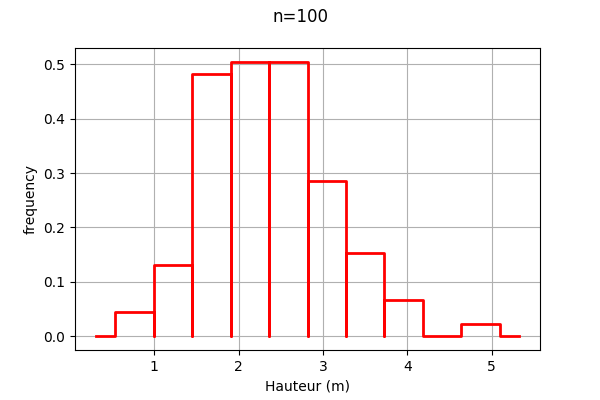

In [4]:
graph = ot.VisualTest_DrawHistogram(Hobs)
graph.setXTitle("Hauteur (m)")
graph.setTitle("n=%s" % (nbobs))
graph.setLegends([""])
graph

Puis on définit la fonction crue, qui possède 4 entrées Q, Ks, Zv, Zm et une sortie H.

In [5]:
def functionCrueModel(X):
    Q, K_s, Z_v, Z_m = X
    L = 5.0e3
    B = 300.0
    alpha = (Z_m - Z_v)/L
    H = (Q/(K_s*B*sqrt(alpha)))**(3.0/5.0)
    return [H]

In [6]:
modelPyFunc = ot.PythonFunction(4, 1, functionCrueModel)
modelPyFunc.setDescription(["Q", "Ks", "Zv", "Zm","H"])

Les lignes suivantes créent la fonction de calage à partir de la fonction modèle :
* les entrées X sont à l'indice 0,
* les variables de calage sont aux indices 1, 2, 3,
* les observations sont données dans `Qobs`.

In [7]:
KsInitial = 25.
ZvInitial = 47.
ZmInitial = 53.
thetaB = ot.Point([KsInitial,ZvInitial,ZmInitial])

In [8]:
calibratedIndices = [1,2,3]
mycf = ot.ParametricFunction(modelPyFunc, calibratedIndices, thetaB)
mycf(Qobs[0])

class=Point name=Unnamed dimension=1 values=[2.25519]

## Propagation des lois à priori

Une condition de compatibilité est requise entre Zv et Zm. Sinon, il se peut que $Z_v\geq Z_m$, ce qui n'est pas compatible avec le modèle.
* Soit le vecteur moyen est tel que, compte tenu de la variance de chaque variable, la probabilité que $Z_v\geq Z_m$ est très faible.
* Soit une dépendance entre $Z_v$ et $Z_m$ implique que la probabilité que $Z_v\geq Z_m$ est très faible.

In [9]:
# Ecart-type des paramètres
sigmaKs = 7.
sigmaZv = 1.
sigmaZm = 1.
sigmaTheta = [sigmaKs,sigmaZv,sigmaZm]

In [10]:
Sigma = ot.CovarianceMatrix(3)
Sigma[0,0] = sigmaKs
Sigma[1,1] = sigmaZv
Sigma[2,2] = sigmaZm
Sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[7,0,0,0,1,0,0,0,1]

In [11]:
prior = ot.Normal(thetaB,Sigma)

In [12]:
n = 100

In [13]:
theta = prior.getSample(n)

In [14]:
Hpredicted = ot.Sample(nbobs,n)
for i in range(nbobs):
    for j in range(n):
        mycf.setParameter(theta[j])
        Hpredicted[i,j] = mycf(Qobs[i])[0]

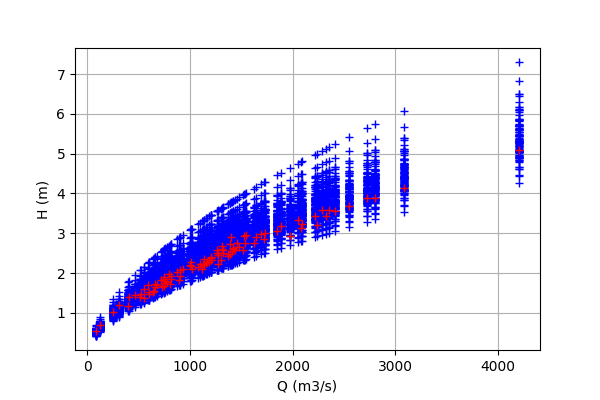

In [15]:
graph = ot.Graph("","Q (m3/s)","H (m)",True)
# Predictions
for i in range(nbobs):
    Qobs_i = ot.Point(n)
    for j in range(n):
        Qobs_i[j] = Qobs[i,0]
    cloud = ot.Cloud(Qobs_i,Hpredicted[i,:])
    graph.add(cloud)
# Observations
cloud = ot.Cloud(Qobs,Hobs)
cloud.setColor("red")
graph.add(cloud)
graph

Since the predictions (in blue) are well within the observations (in red), the model can be calibrated.